In [1]:
#전처리 코드 확인 필요 X
import pandas as pd
import numpy as np

df11=pd.read_csv('C:\\Users\\장재요원지\\Downloads\\merged_dataset_post_with_images_with_captions.csv',encoding='utf-8-sig')
df=df11
#df = pd.read_csv('C:\\Users\\장재요원지\\Downloads\\merged_dataset_post_with_images_with_captions.csv', encoding='utf-8')

def count_hashtags(x):
    if pd.isna(x):
        return 0
    # 빈 문자열 처리
    x = x.strip()
    if not x:
        return 0
    return len([tag for tag in x.split(',') if tag.strip()])

df['hashtag_count'] = df['hashtags'].apply(count_hashtags)
df['mention_count'] = df['mentions'].apply(count_hashtags)
df=df.drop(columns=['mentions','hashtags'])
df=df[df['caption'].isna()==False]

df_captionlen=df['caption'].apply(lambda x: len(x))
df['captionlen']=df_captionlen

from datetime import datetime

df["day_of_week"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%A"))
df["hour"] = df["timestamp"].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%H")))
df["day_of_year"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y"))

In [2]:
#전처리 코드 확인 필요 X 2

df2=df.drop(columns=['caption','timestamp','owner_fullName','owner_verified','owner_biography','isSponsored','images'])

df2['day_of_year']=df2['day_of_year'].astype(int)
df2 = pd.get_dummies(
    df2,
    columns=['day_of_week', 'owner_businessCategoryName'],
    dtype=int  # int로 지정
)
df2=df2[df2['owner_id'].isna()==False]

df2 = df2[df2['likesCount'] >= 0]
# owner_id별 likesCount 평균
df2['owner_avg_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('mean')

# owner_id별 likesCount 중앙값
df2['owner_median_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('median')
df2['owner_median_commentCount'] = df2.groupby('owner_id')['commentsCount'].transform('median')
df2['owner_var_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('var')
# 표준편차 컬럼 추가 (루트 분산)
df2['owner_std_likesCount'] = np.sqrt(df2['owner_var_likesCount'])
df2['mean_impress']=df2['owner_avg_likesCount']/df2['owner_followersCount']
# 최종 좋아요 예측하기
y = df2['likesCount'] # y는 likesCount와 commentsCount

x = df2.drop(columns=['owner_businessCategoryName_None,Health/beauty','mean_impress','owner_median_commentCount','owner_id','likesCount', 'commentsCount','impression'])  # 나머지 열은 x
#x = df2.drop(columns=['likesCount', 'impression'])  # 나머지 열은 x

# owner_followersCount의 각 값의 개수를 세기
counts = x['owner_followersCount'].value_counts()
print(counts)
x = x[x['owner_followersCount'].isin(counts[counts > 1].index)]
y = y[x.index]

owner_followersCount
2459253.0    144
1011338.0     88
189595.0      85
347415.0      81
562380.0      64
28214.0       61
236233.0      51
467836.0      50
334943.0      50
100081.0      45
559518.0      39
564283.0      33
255675.0      20
292326.0      13
72922.0       13
169886.0      12
550161.0      12
422331.0       8
13550.0        7
34772.0        6
127966.0       5
372155.0       3
25570.0        1
Name: count, dtype: int64


In [3]:
#캡션 임베딩 모델 로드 
from sentence_transformers import SentenceTransformer

# 최적화된 모델 선택 (384차원 출력)
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\장재요원지\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# 텍스트 추출
texts = x['image_captions'].tolist()

# 임베딩 변환 (CPU 기본 실행)
embeddings = model.encode(texts, show_progress_bar=True)

# 결과 확인
print(f"입력 텍스트 수: {len(texts)}")
print(f"출력 차원: {embeddings.shape[1]}")  # 384 확인

# 데이터프레임에 저장
x['image_embeddings'] = embeddings.tolist()

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

입력 텍스트 수: 890
출력 차원: 384


In [5]:

# 임베딩 배열 변환
embeddings_array = np.vstack(x['image_embeddings'].values)
print(f"입력 차원: {embeddings_array.shape}")  # (890, 384)

입력 차원: (890, 384)


In [6]:
#1차원 압축 (이미지 캡션)

import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

# 오토인코더 모델 정의 (단순화 버전)
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)  # 1차원 압축
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(384)  # 원본 차원 복원
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# 학습 실행 (5분 내외)
history = autoencoder.fit(embeddings_array, embeddings_array,
                         epochs=50, batch_size=32, verbose=1)

# 압축 및 복원
compressed = encoder.predict(embeddings_array)  # (890, 1)
reconstructed = autoencoder.predict(embeddings_array)  # (890, 384)

# 코사인 유사도 계산
cos_sim = cosine_similarity(embeddings_array, reconstructed).diagonal()
print(f"평균 코사인 유사도: {np.mean(cos_sim):.4f}")

# 결과 저장
x['compressed_1d'] = compressed.tolist()


Epoch 1/50

28/28 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 11/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 12/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 13/50
28/28 [============================

In [7]:
#x 1차원압축완료 및 object 컬럼 제거

x['compressed_1d'] = x['compressed_1d'].apply(lambda val: val[0])
x.drop(columns=['image_captions','image_embeddings'],inplace=True)


owner_followersCount                                    float64
owner_postsCount                                        float64
hashtag_count                                             int64
mention_count                                             int64
captionlen                                                int64
hour                                                      int64
day_of_year                                               int32
day_of_week_Friday                                        int32
day_of_week_Monday                                        int32
day_of_week_Saturday                                      int32
day_of_week_Sunday                                        int32
day_of_week_Thursday                                      int32
day_of_week_Tuesday                                       int32
day_of_week_Wednesday                                     int32
owner_businessCategoryName_Actor                          int32
owner_businessCategoryName_Album        

In [46]:
#필요한 정보-> 팔로워수, 해시태그 개수, 멘션개수, 캡션길이, 올리는 시간, 요일, 계정종류, 이미지 캡션

selected_features = ['owner_followersCount', 'hashtag_count',
       'mention_count', 'captionlen', 'hour', 'day_of_year',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'owner_businessCategoryName_Actor',
       'owner_businessCategoryName_Album', 'owner_businessCategoryName_Artist',
       'owner_businessCategoryName_Clothing (Brand)',
       'owner_businessCategoryName_Comedy club',
       'owner_businessCategoryName_Community',
       'owner_businessCategoryName_Digital creator',
       'owner_businessCategoryName_Model',
       'owner_businessCategoryName_Motivational speaker',
       'owner_businessCategoryName_Movie/television studio',
       'owner_businessCategoryName_None,Media',
       'owner_businessCategoryName_None,News & media website',
       'owner_businessCategoryName_None,Shopping & retail',
       'owner_businessCategoryName_None,Video creator',
       'owner_businessCategoryName_Scientist',
       'owner_businessCategoryName_Video creator',
        'compressed_1d']


In [74]:
len(selected_features)

30

In [36]:
x.columns

Index(['owner_followersCount', 'owner_postsCount', 'hashtag_count',
       'mention_count', 'captionlen', 'hour', 'day_of_year',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'owner_businessCategoryName_Actor',
       'owner_businessCategoryName_Album', 'owner_businessCategoryName_Artist',
       'owner_businessCategoryName_Clothing (Brand)',
       'owner_businessCategoryName_Comedy club',
       'owner_businessCategoryName_Community',
       'owner_businessCategoryName_Digital creator',
       'owner_businessCategoryName_Model',
       'owner_businessCategoryName_Motivational speaker',
       'owner_businessCategoryName_Movie/television studio',
       'owner_businessCategoryName_None,Media',
       'owner_businessCategoryName_None,News & media website',
       'owner_businessCategoryName_None,Shopping & retail',
       'owner_businessCategoryName_N

In [57]:
#ramdomforeast
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=102)

# 선택된 피처로 데이터 선택
x_train_sel1 = x_train.loc[:, selected_features]
x_test_sel1 = x_test.loc[:, selected_features]

# MinMax 스케일링
scaler = MinMaxScaler()
x_train_sel = scaler.fit_transform(x_train_sel1)
x_test_sel = scaler.transform(x_test_sel1)


x_t = x_test

# 랜덤포레스트 모델 정의 및 학습

#model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#하이퍼파라미터 튜닝 결과
model = RandomForestRegressor(
    n_estimators=112,
    max_depth=13,
    min_samples_split=9,
    min_samples_leaf=3,
    max_features=None,
    random_state=42,
    n_jobs=-1
)


# 선택된 피처로 학습
model.fit(x_train_sel, y_train)

# 예측
y_pred = model.predict(x_test_sel)

# sMAPE 함수 정의
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-8  # 0으로 나누는 것 방지
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100


# 평가 - 피처셀렉 했을 때
print("피쳐셀렉 햇을때")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.8f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score: {r2:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mean_absolute_percentage_erro: {mape:.2f}")

owner_std = np.sqrt(x_t['owner_var_likesCount'].values)  # 표준편차로 변환
owner_std[owner_std == 0] = 1
nmae = np.mean(np.abs(y_test - y_pred) / owner_std)
print(f"Normalized MAE (by user group std): {nmae:.5f}")

smape_val = smape(y_test.values, y_pred)
print(f"sMAPE: {smape_val:.2f}%")


피쳐셀렉 햇을때
Mean Squared Error: 582364484.40184796
Mean Absolute Error: 12893.29552
R² Score: 0.72
mean_absolute_percentage_erro: 0.68
Normalized MAE (by user group std): 0.63548
sMAPE: 42.66%


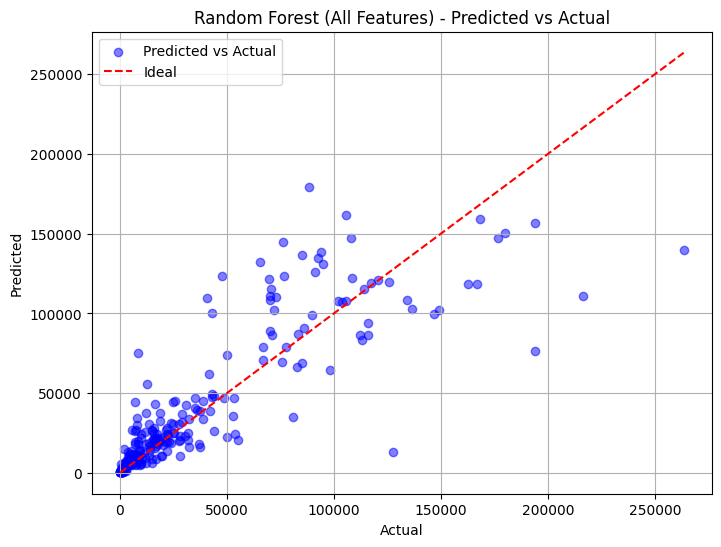

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest (All Features) - Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#유저데이터 전처리

In [79]:
user_input = {
    "owner_followersCount": 500001,            # 팔로워 수
    "hashtags": ['travel', 'sunset'],                  # 예: ['travel', 'sunset']
    "mentions": ['@friend1', '@brand'],                  # 예: ['@friend1', '@brand']
    "caption": 'i like play football',                         # 인스타 텍스트 설명
    "timestamp": '2025-06-05 14:30:00',                       # '2025-06-05 14:30:00' 형식
    "owner_businessCategoryName": 'Digital creator',      # 예: 'Digital creator'
    "image_caption": 'the man play football with father'                    # 이미지 캡션 문장
}

In [80]:
hashtag_count = len(user_input['hashtags'])
mention_count = len(user_input['mentions'])
captionlen = len(user_input['caption']) if pd.notna(user_input['caption']) else 0


In [81]:
timestamp = pd.to_datetime(user_input['timestamp'])
hour = timestamp.hour
day_of_year = timestamp.dayofyear
day_of_week = timestamp.day_name()  # 예: 'Friday'


In [82]:
# day_of_week 원-핫 벡터
dow_features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
day_of_week_onehot = {f'day_of_week_{d}': int(day_of_week == d) for d in dow_features}

# business category 원-핫 벡터
bc_features = [
    'Actor', 'Album', 'Artist', 'Clothing (Brand)', 'Comedy club', 'Community',
    'Digital creator', 'Model', 'Motivational speaker', 'Movie/television studio',
    'None,Media', 'None,News & media website', 'None,Shopping & retail',
    'None,Video creator', 'Scientist', 'Video creator'
]
businessCategory = user_input['owner_businessCategoryName']
bc_onehot = {f'owner_businessCategoryName_{b}': int(businessCategory == b) for b in bc_features}


In [83]:
# sentence embedding
from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
caption_embedding = embedding_model.encode([user_input['image_caption']])  # shape: (1, 384)

# autoencoder encoder 모델을 통해 압축된 1차원 임베딩 추출
caption_embedding_tf = tf.convert_to_tensor(caption_embedding, dtype=tf.float32)
compressed_1d = encoder.predict(caption_embedding_tf)[0][0]

2025-06-06 00:45:59,587 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-06-06 00:45:59,601 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\장재요원지\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


In [84]:
final_input_dict = {
    "owner_followersCount": user_input['owner_followersCount'],
    "hashtag_count": hashtag_count,
    "mention_count": mention_count,
    "captionlen": captionlen,
    "hour": hour,
    "day_of_year": day_of_year,
    **day_of_week_onehot,
    **bc_onehot,
    "compressed_1d": compressed_1d
}

In [85]:
final_input_dict

{'owner_followersCount': 500001,
 'hashtag_count': 2,
 'mention_count': 2,
 'captionlen': 20,
 'hour': 14,
 'day_of_year': 156,
 'day_of_week_Friday': 0,
 'day_of_week_Monday': 0,
 'day_of_week_Saturday': 0,
 'day_of_week_Sunday': 0,
 'day_of_week_Thursday': 1,
 'day_of_week_Tuesday': 0,
 'day_of_week_Wednesday': 0,
 'owner_businessCategoryName_Actor': 0,
 'owner_businessCategoryName_Album': 0,
 'owner_businessCategoryName_Artist': 0,
 'owner_businessCategoryName_Clothing (Brand)': 0,
 'owner_businessCategoryName_Comedy club': 0,
 'owner_businessCategoryName_Community': 0,
 'owner_businessCategoryName_Digital creator': 1,
 'owner_businessCategoryName_Model': 0,
 'owner_businessCategoryName_Motivational speaker': 0,
 'owner_businessCategoryName_Movie/television studio': 0,
 'owner_businessCategoryName_None,Media': 0,
 'owner_businessCategoryName_None,News & media website': 0,
 'owner_businessCategoryName_None,Shopping & retail': 0,
 'owner_businessCategoryName_None,Video creator': 0,
 '

In [86]:
import pandas as pd

# 1행짜리 DataFrame 생성
input_df = pd.DataFrame([final_input_dict])

# 모델이 기대하는 컬럼 순서대로 정렬
input_df = input_df[selected_features]


In [92]:
y_pred_user = model.predict(input_df)  # 모델 예측 (회귀값)
print(y_pred_user[0])


C:\Users\장재요원지\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


138493.84693849058


In [ ]:
###########밑에는 RAG langchain

In [88]:
import os
import langchain
import faiss
import PyPDF2
# 환경 변수로 API 키 설정
os.environ["GOOGLE_API_KEY"] = ""
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini 1.5 Flash 모델로 설정
llm = ChatGoogleGenerativeAI(
    model="models/gemini-1.5-flash-latest",  # ← 이 부분만 변경!
    temperature=0.7
)

2025-06-06 01:11:54,903 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-06-06 01:11:56,543 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-06-06 01:11:56,695 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [ ]:
#'C:\\Users\\장재요원지\\Downloads\\merged_dataset_post_with_images_with_captions.csv'

In [89]:
from langchain_community.document_loaders import PyPDFLoader

file_path = r'insta_context.pdf'

loader = PyPDFLoader(file_path)
docs = loader.load()

# 전체 페이지 수 확인
print(f"총 페이지 수: {len(docs)}")

# 각 페이지별 내용 미리보기
for i, doc in enumerate(docs):
    print(f"\n--- Page {i+1} ---")
    print(doc.page_content[:500]) 

총 페이지 수: 162

--- Page 1 ---
THE ULTIMATE GUIDE TO 
INSTAGRAM MARKETING
Whether you’re B2B or B2C, there’s a path 
to Instagram success.

--- Page 2 ---
LET’S GET STARTED
If your brand’s not on Instagram, it should be. And if it already is, there’s 
always room for improvement. Let’s start with the stats: 
• Today, there are 500 million monthly active Instagram users 
• 95 million photos and videos are shared every day 
• Photos earn 4.2 billion likes per day 
• Research ﬁrm L2 found that Instagram had the highest conversion rate – 
more than 15 times that of Facebook 
• The average engagement rate on Instagram is 2.26% vs Facebook’s 0.21% 
and 

--- Page 3 ---
HOW TO SET, MEASURE AND TRACK YOUR 
INSTAGOALS
SET YOUR GOALS 
Before you embark on your Instagram journey, you need to start with one question: Why am I  
doing this? 
Deﬁning your “why” helps you to set measurable targets to track your success. Every business 
has diﬀerent goals when it comes to their social media marketing, a

In [100]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate


# 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

# 3. 임베딩 모델 설정
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# 4. FAISS 벡터 저장소 생성
vectorstore = FAISS.from_documents(split_docs, embedding_model)

# 5. QA 체인 구성
retriever = vectorstore.as_retriever()
llm = ChatGoogleGenerativeAI(model="models/gemini-1.5-flash", temperature=0)

# PromptTemplate 설정
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
너는 인스타그램 게시물 흥행 전략 유료 리포트를 짜주는 프로그램이야 
좋아요 수를 더 높이기 위해 어떤 요소를 개선해야 할지 전문가처럼 전략을 반드시 context참고해서 제시해주세요.
context 문서를 참고해, 구체적으로 어떻게 하면 좋을지 자세한 가이드를 context를 참조해서 알려줘
이 프로그램 사용자에게 리포트를 제시해주는거야 
리포트 형식은 보고서처럼 깔끔하게 당신의 좋아요수를 제시하여주고, 여러
"제공해주신 정보 를 바탕으로" 이런내용은 빼 이런 정보는 서비스 개발자인 내가 주는거고 너는 유저에게 결과를 자신감있게 제시하는거야
먼저 이 정보를 바탕으로 예상되는 좋아요 예측을 제시해주고, 내 다른 인스타 계정 정보를 바탕으로


    내가 좋아요 수를 지금보다 더 올리려면 어느부분을 조정해야하는지 context문서를 참고하여서 
    가이드 리포트를 제공해줘 반드시 context문서를 참고해주어야해 매우 자세하게 작성해주고 전문가 처럼
    말해주면서 자신감있게 전략을 제시해줘 구체적인 숫자를 근거로 들어 제시해도 돼

    '*'문자 절대 쓰지마

    아래는 이 리포트의 양식입니다.

    
    인스타그램 성장전략 리포트
    
    예상 좋아요 수: '숫자 '

본 보고서는 최첨단 예측 기술을 바탕으로 작성되었으며, 제공된 정보를 바탕으로 게시물의 잠재력을 극대화하기 위한 전략을 제시합니다. ~~~~ 


1. 콘텐츠 분석 및 개선 방향

주제:

해시태그: 

멘션: 
이미지: 

캡션:


2.  최적화 전략

시간대:  

이모티콘:  

위치 태그:

카테고리: 

3.  추가적인 고려 사항




**결론:**


위의 양식 구조를 이용해서 써주되 반드시 'context'를 참조하고, 분량을 매우 자세하고 길게 5페이지 이상은 나오게끔 매우 자세히  써줘 분량을 엄청 길게해야해 명심해 엄청 길게
    
    
문서 내용:
{context}

학생 질문:
{question}


  
"""
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": custom_prompt}
)

'''
user_input = {
    "owner_followersCount": 500001,            # 팔로워 수
    "hashtags": ['travel', 'sunset'],                  # 예: ['travel', 'sunset']
    "mentions": ['@friend1', '@brand'],                  # 예: ['@friend1', '@brand']
    "caption": 'i like play football',                         # 인스타 텍스트 설명
    "timestamp": '2025-06-05 14:30:00',                       # '2025-06-05 14:30:00' 형식
    "owner_businessCategoryName": 'Digital creator',      # 예: 'Digital creator'
    "image_caption": 'the man play football with father'                    # 이미지 캡션 문장
}
'''
# 7. 질문 구성
query = f"""

현재 팔로워 수는 {user_input['owner_followersCount']}명, 해시태그는 {user_input['hashtags']}이며, 멘션는 {user_input['mentions']} 사용중입니다.
이용자가 작성하려는 캡션은 {user_input['caption']} 입니다. 작성시간은  {user_input['timestamp']}이고 계정 카테고리는 {user_input['owner_businessCategoryName']}입니다.
이용자가 올리려는 그림을 한줄로 설명하면 {user_input["image_caption"]}이다.

우리의 최첨단 예측 기술을 바탕으로 이 게시물의 좋아요수는 약 {y_pred_user[0]}으로 예측되었습니다.

먼저 좋아요 수 예측 결과를 제시해주며 이는 최첨단 예측 기술을 바탕으로 제시되었다고 말해주고 사용자 분석리포트를 작성해줘

"""

# 8. 실행
response = qa_chain.run(query)

#print("🔍 질문:", query)
print( response)

인스타그램 성장전략 리포트

예상 좋아요 수: 138,494

본 보고서는 최첨단 예측 기술을 바탕으로 작성되었으며, 제공된 정보를 바탕으로 게시물의 잠재력을 극대화하기 위한 전략을 제시합니다.  제공된 정보(팔로워 수 500,001명, 해시태그 #travel, #sunset, 멘션 @friend1, @brand, 캡션 "I like play football", 게시 시간 2025년 6월 5일 14시 30분, 계정 카테고리 Digital Creator, 이미지 "아버지와 함께 축구하는 남자" )를 분석하여,  좋아요 수를 극대화할 수 있는 구체적인 전략을 수립했습니다.  현재 예상 좋아요 수는 138,494개이지만, 아래 제시된 전략을 적용하면 이 수치를 상당히 뛰어넘을 수 있을 것으로 예상됩니다.


1. 콘텐츠 분석 및 개선 방향

**주제:** 현재 주제는 "아버지와 함께 축구하는 남자"로,  감성적인 스토리텔링을 통해 더 많은 공감을 얻을 수 있습니다.  단순히 "축구를 좋아한다"는 내용보다, 아버지와 함께하는 시간의 소중함,  추억,  가족애 등을 부각하는 방향으로 주제를 확장하는 것이 좋습니다.  예를 들어, "아버지와의 특별한 축구 시간", "잊지 못할 아버지와의 추억", "아버지와 함께라면 어디든 즐겁다" 와 같은 주제로 변경하는 것을 고려해 보세요.

**해시태그:**  #travel 과 #sunset 은 여행 사진에 적합하지만,  축구를 하는 사진에는 적절하지 않습니다.  더욱 효과적인 해시태그 전략을 위해 다음과 같은 해시태그를 추가하거나 변경하는 것을 권장합니다.

* **주요 해시태그:** #football, #soccer, #fatherandson, #familytime, #sports, #happy, #love, #instagood, #photooftheday  등 축구와 가족, 긍정적인 감정을 표현하는 해시태그를 사용하세요.
* **니치 해시태그:**  더욱 구체적인 해시태그를 사용하여 특정 대상에게 도달할 수 있습니다. 예를 들어

In [ ]:
#####끝

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# sMAPE 정의
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-8
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100

# 데이터 전처리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=102)

x_train_sel1 = x_train[selected_features]
x_test_sel1 = x_test[selected_features]

scaler = MinMaxScaler()
x_train_sel = scaler.fit_transform(x_train_sel1)
x_test_sel = scaler.transform(x_test_sel1)

x_t = x_test  # owner_std 계산용

# Optuna 목적 함수 정의
# 목적 함수 수정 (MAPE 최소화)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    model.fit(x_train_sel, y_train)
    y_pred = model.predict(x_test_sel)

    # MAPE를 최소화 (loss 기준)
    r2=r2_score(y_test, y_pred)
    smape_val = smape(y_test.values, y_pred)
    return smape_val/r2

# Optuna 스터디 실행 (direction='minimize'로 변경)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


# 최적 파라미터 출력
print("\nBest hyperparameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# 최적 파라미터로 최종 모델 학습 및 평가
best_model = RandomForestRegressor(**study.best_params)
best_model.fit(x_train_sel, y_train)
y_pred = best_model.predict(x_test_sel)

print("\n[최적화된 RandomForest 성능 평가]")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.8f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

owner_std = np.sqrt(x_t['owner_var_likesCount'].values)
owner_std[owner_std == 0] = 1
nmae = np.mean(np.abs(y_test - y_pred) / owner_std)
print(f"Normalized MAE (by user group std): {nmae:.5f}")

smape_val = smape(y_test.values, y_pred)
print(f"sMAPE: {smape_val:.2f}%")